# Sandbox for ndoperators.solvers

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc as misc
import math
import imageio

# Operator imports
import ndoperators as ops
import llops as yp

# Solver-specific imports
from ndoperators.solvers import objectivefunctions, regularizers
import ndoperators.solvers as solvers

In [2]:
ops.setDefaultBackend('arrayfire') # arrayfire or numpy
ops.setDefaultDatatype('float32')

global_dtype = yp.config.default_dtype
global_backend = yp.config.default_backend

# Generate Forward Model For Convolutional System with Windowing

/Users/zfphil/.conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


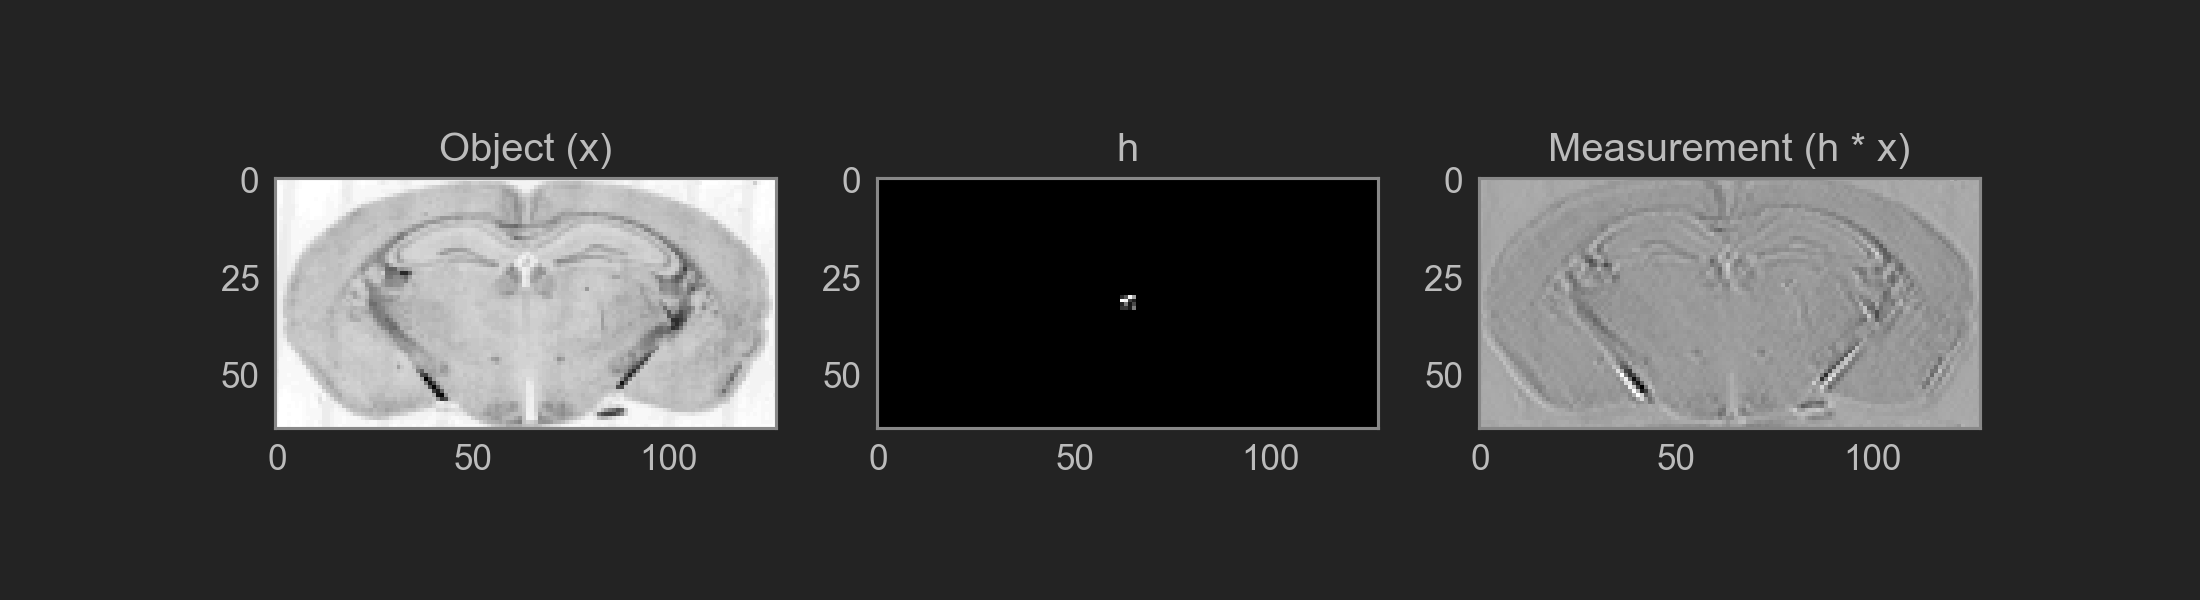

In [4]:
# Image to use when generating object
object_file_name = '../test/brain_to_scan.png'

# Color channel to use when generating object
object_color_channel = 2

# Image size to simulate
image_size = np.array([32, 64]) * 2

# Determine machine precision threshold
eps = yp.precision(global_dtype) * np.prod(image_size)

# Load object and crop to size
brain = imageio.imread(object_file_name)
object_true = np.asfortranarray(sp.misc.imresize(brain, size=image_size)[:, :, object_color_channel].astype(yp.getNativeDatatype(global_dtype, 'numpy')) / 255.)
object_true = yp.asbackend(object_true)

# Determine machine precision threshold
eps = yp.precision(global_dtype) * np.prod(image_size)

# Generate convolution kernel h
h_size = np.array([4, 4])
h = yp.zeros(image_size, global_dtype, global_backend)
h[image_size[0] // 2 - h_size[0] // 2:image_size[0] // 2 + h_size[0] // 2,
  image_size[1] // 2 - h_size[1] // 2:image_size[1] // 2 + h_size[1] // 2] = yp.randn((h_size[0], h_size[1]), global_dtype, global_backend)

h /= yp.scalar(yp.sum(h))

A = ops.Convolution(h, mode='circular')
y = A * object_true

# Show object and h
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(np.abs(np.asarray(object_true)), cmap='gray')
plt.title('Object (x)')
plt.subplot(132)
plt.imshow(np.abs(np.asarray(h)), cmap='gray')
plt.title('h')
plt.subplot(133)
plt.imshow((np.abs(np.asarray(y))).reshape(image_size), cmap='gray')
plt.title('Measurement (h * x)');

## Generate Measurements

In [6]:
# Options
shift_offsets_true = ((0,0) ,(0,10), (0,0))
crop_size = (image_size[0], image_size[0])

# Initializations
x = object_true
s = ((0,0) ,(0,0), (0,0))

# Crop operations
X_list = [ops.Crop(image_size, crop_size, crop_start=(0,0)),
          ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 4)),
          ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 2))]

# Set correct shift offsets
for crop_op, offset in zip(X_list, shift_offsets_true):
    args = crop_op.arguments
    args['crop_offset'] = offset
    crop_op.arguments = args
    
# Stack operators
X = ops.Vstack(X_list)

# Convolution operators
h_crop = ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 4)) * h  #yp.rand(h.shape)
                  
C_list = [ops.Convolution(h_crop, label='C_1'),
          ops.Convolution(h_crop, label='C_2'),
          ops.Convolution(h_crop, label='C_3')]
C = ops.Dstack(C_list)

# Registration Operators
R_list = [ops.Registration(x, inside_operator=X) for X in X_list]
R = ops.Dstack(R_list)

# Create Composite Operators
A_shift = C * R
A_object = C * X

# Generate measurements
y = A_object * object_true

# Generate objective functions
O_shift = objectivefunctions.L2(A_shift, y)
O_object = objectivefunctions.L2(A_object, y)

O_shift.latex()
O_object.latex()

# Show results
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(yp.abs(x), cmap='gray')
plt.colorbar()
plt.subplot(132)
plt.imshow(yp.abs(y), cmap='gray')
plt.colorbar()
plt.subplot(133)
plt.imshow(yp.abs(O_object.invert()), cmap='gray')
# plt.colorbar()

IndexError: In function void assign(Array<T> &, const vector<af_seq>, const af_array &) [T = float]
In file src/api/c/assign.cpp:108
Invalid type for argument 1


## Operator-Based Solution